# Bitcoin Trend Prediction using AI Models

### Elastic Net • XGBoost • LSTM

## Setup & Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)

from xgboost import XGBClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
import os, random, numpy as np, tensorflow as tf

# Results deterministic
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

## Load & Inspect Dataset

In [3]:
# Load dataset
df = pd.read_csv(r"C:\Users\Minec\Desktop\BTC-Price-Predictor\data\BTC_USD_COMPLETE_ANALYSIS_20250907_220628.csv")

print("Shape:", df.shape)
df.head()

Shape: (4009, 113)


,Date,open,high,low,close,volume,daily_return_pct,weekly_return_pct,monthly_return_pct,yearly_return_pct,...,high_volume_breakout,golden_cross,death_cross,breakout_20d_high,breakdown_20d_low,rsi_overbought,rsi_oversold,rsi_divergence,macd_bullish_cross,macd_bearish_cross
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,-7.192558,NaN,NaN,NaN,...,False,False,False,False,False,False,True,False,False,True
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,-6.984265,NaN,NaN,NaN,...,False,False,False,False,False,False,True,False,False,False
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,3.573492,NaN,NaN,NaN,...,False,False,False,False,False,False,True,False,False,False
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,-2.465854,NaN,NaN,NaN,...,False,False,False,False,False,False,True,False,False,False


## Preprocessing & Train / Validation / Test Split

In [4]:
df["Target"] = (df["close"].shift(-1) > df["close"]).astype(int)

# Drop the last row
df = df[:-1].reset_index(drop=True)

print("After adding Target + dropping last row:", df.shape)

print(df[["Date", "close", "Target"]].head(10))
print(df[["Date", "close", "Target"]].tail(10))

After adding Target + dropping last row: (4008, 114)
         Date       close  Target
0  2014-09-17  457.334015       0
1  2014-09-18  424.440002       0
2  2014-09-19  394.795990       1
3  2014-09-20  408.903992       0
4  2014-09-21  398.821014       1
5  2014-09-22  402.152008       1
6  2014-09-23  435.790985       0
7  2014-09-24  423.204987       0
8  2014-09-25  411.574005       0
9  2014-09-26  404.424988       0
            Date          close  Target
3998  2025-08-28  112544.804688       0
3999  2025-08-29  108410.835938       1
4000  2025-08-30  108808.070312       0
4001  2025-08-31  108236.710938       1
4002  2025-09-01  109250.593750       1
4003  2025-09-02  111200.585938       1
4004  2025-09-03  111723.210938       0
4005  2025-09-04  110723.601562       0
4006  2025-09-05  110650.984375       0
4007  2025-09-06  110224.695312       1


## Define features X and target y

In [6]:
# Drop columns NOT used as predictors
X = df.drop(["Target", "Date", "close"], axis=1)
y = df["Target"]

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

# Quick preview
print("\nFirst 5 rows of X:")
print(X.head())

print("\nFirst 5 values of y:")
print(y.head())

Feature matrix shape: (4008, 111)
Target vector shape: (4008,)

First 5 rows of X:
         open        high         low    volume  daily_return_pct  \
0  465.864014  468.174011  452.421997  21056800               NaN   
1  456.859985  456.859985  413.104004  34483200         -7.192558   
2  424.102997  427.834991  384.532013  37919700         -6.984265   
3  394.673004  423.295990  389.882996  36863600          3.573492   
4  408.084991  412.425995  393.181000  26580100         -2.465854   

   weekly_return_pct  monthly_return_pct  yearly_return_pct  volatility_7d  \
0                NaN                 NaN                NaN            NaN   
1                NaN                 NaN                NaN            NaN   
2                NaN                 NaN                NaN            NaN   
3                NaN                 NaN                NaN            NaN   
4                NaN                 NaN                NaN            NaN   

   volatility_14d  ...  high_volu

In [7]:
# Convert object columns to numeric categories
for col in X.columns:
    if X[col].dtype == "object":
        X[col] = X[col].astype("category").cat.codes


## Time-based train/test split (no shuffle)

In [8]:
from sklearn.model_selection import train_test_split
from collections import Counter

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    shuffle=False   # VERY important for time-series
)

print("Train X shape:", X_train.shape)
print("Test X shape :", X_test.shape)
print("Train y shape:", y_train.shape)
print("Test y shape :", y_test.shape)

print("\nClass balance in TRAIN set:", Counter(y_train))
print("Class balance in TEST set :", Counter(y_test))


Train X shape: (3206, 111)
Test X shape : (802, 111)
Train y shape: (3206,)
Test y shape : (802,)

Class balance in TRAIN set: Counter({1: 1703, 0: 1503})
Class balance in TEST set : Counter({1: 409, 0: 393})


## Model Testing

## XGBoost Classfier

In [9]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

xgb_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=200,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Predictions
xgb_pred = xgb_model.predict(X_test)

# Metrics
xgb_acc = accuracy_score(y_test, xgb_pred)
xgb_prec = precision_score(y_test, xgb_pred)
xgb_rec = recall_score(y_test, xgb_pred)
xgb_f1 = f1_score(y_test, xgb_pred)

print("\n=== XGBoost Results ===")
print(f"Accuracy : {xgb_acc:.4f}")
print(f"Precision: {xgb_prec:.4f}")
print(f"Recall   : {xgb_rec:.4f}")
print(f"F1 Score : {xgb_f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, xgb_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, xgb_pred)
print("\nConfusion Matrix:")
print(cm)



=== XGBoost Results ===
Accuracy : 0.5162
Precision: 0.5600
Recall   : 0.2396
F1 Score : 0.3356

Classification Report:
              precision    recall  f1-score   support

           0     0.5040    0.8041    0.6196       393
           1     0.5600    0.2396    0.3356       409

    accuracy                         0.5162       802
   macro avg     0.5320    0.5218    0.4776       802
weighted avg     0.5326    0.5162    0.4748       802


Confusion Matrix:
[[316  77]
 [311  98]]


## Confusion Matrix - XGBoost Classifier

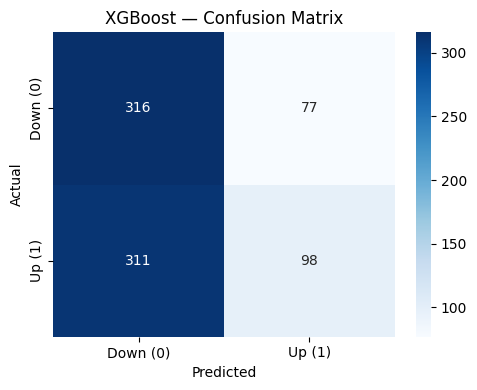

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, xgb_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Down (0)", "Up (1)"],
            yticklabels=["Down (0)", "Up (1)"])
plt.title("XGBoost — Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


## Elastic Net Logistic Regression Classification

In [14]:
# Handle NaN values 
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
X_train_en = imputer.fit_transform(X_train)
X_test_en = imputer.transform(X_test)

scaler_en = StandardScaler()
X_train_en = scaler_en.fit_transform(X_train_en)
X_test_en = scaler_en.transform(X_test_en)

In [15]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Impute NaNs
imputer = SimpleImputer(strategy="median")
X_train_en = imputer.fit_transform(X_train)
X_test_en = imputer.transform(X_test)

# Scale features
scaler_en = StandardScaler()
X_train_en = scaler_en.fit_transform(X_train_en)
X_test_en = scaler_en.transform(X_test_en)

# Define Elastic Net model
elastic_model = LogisticRegression(
    penalty="elasticnet",
    l1_ratio=0.5,
    solver="saga",
    max_iter=5000,
    random_state=42
)

# Train
elastic_model.fit(X_train_en, y_train)

# Predict
elastic_pred = elastic_model.predict(X_test_en)

# Metrics
en_acc = accuracy_score(y_test, elastic_pred)
en_prec = precision_score(y_test, elastic_pred)
en_rec = recall_score(y_test, elastic_pred)
en_f1 = f1_score(y_test, elastic_pred)

print("\n=== Elastic Net (Logistic) Results ===")
print(f"Accuracy : {en_acc:.4f}")
print(f"Precision: {en_prec:.4f}")
print(f"Recall   : {en_rec:.4f}")
print(f"F1 Score : {en_f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, elastic_pred, digits=4))

# Confusion Matrix
cm_en = confusion_matrix(y_test, elastic_pred)
print("\nConfusion Matrix:")
print(cm_en)



=== Elastic Net (Logistic) Results ===
Accuracy : 0.5723
Precision: 0.5602
Recall   : 0.7506
F1 Score : 0.6416

Classification Report:
              precision    recall  f1-score   support

           0     0.5984    0.3868    0.4699       393
           1     0.5602    0.7506    0.6416       409

    accuracy                         0.5723       802
   macro avg     0.5793    0.5687    0.5557       802
weighted avg     0.5789    0.5723    0.5574       802


Confusion Matrix:
[[152 241]
 [102 307]]


## Confusion Matrix - Elastic Net

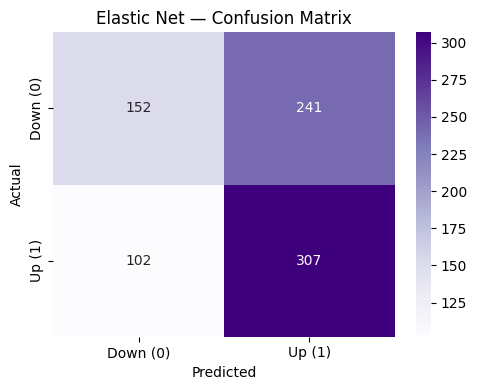

In [16]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_en, annot=True, fmt="d", cmap="Purples",
            xticklabels=["Down (0)", "Up (1)"],
            yticklabels=["Down (0)", "Up (1)"])
plt.title("Elastic Net — Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
